## Building the Ising lattice class

We are now going to illustrate the concept of "class" for our example. Our aim is to obtain
a class which describes the lattice of arrows/spins, which you'll be able to manipulate at ease to
implement your Monte Carlo Metropolis simulation. 

We start by importing the relevant modules :



In [84]:
import numpy as np  # package for arrays
import matplotlib.pyplot as plt  # package for plotting
import time  # for timing
%matplotlib inline




We have an $M$ by $N$ lattice of spins/arrows, at each site $i$ of a two dimensional grid (or lattice), we have a variable $\sigma_i \in \{-1, 1\}$, called hereafter the spin at site $i$. 

The energy of the system is for a given spin configuration:

$\sum_{<i,j>}  -J \sigma_i \sigma_j $
    
where the <,> denotes a sum over nearest neighbors, meaning i and j are sites with a distance $|i-j|=1$, and the lattice is a grid with dimension $M$ by $N$.

At this stage, you can already tell something will go wrong when a site $i$ sits at the boundary of this grid, 
as it has less than 4 neighbors. Ideally we'd simulate an infinite grid, but that would go beyond what we can
do with a computer. The best we can do is minimize the impact of the boundary, such that each site of the lattice
"sees" the same number of neighbors (4 in our case). 

A mathematical trick is to imagine that the sites at one boundary are connected, or see, the sites at the
other boundary. This is called "periodic boundary conditions". This helps mimicing a system of infinite extent. 
The boundary conditions is applied in both directions, horizontal and vertical, and you can hence imaginge
the 2D grid as having a donut topology (torus), where both directions x and y are closed on themselves and 
periodic. 


We can very slightly generalize this model by adding a coupling to an external magnetic field $h$. This 
external field will tend to align all the spins/arrows in the same direction, when $h$ is large. The model
is simply generalized by adding an extra term: 

$\sum_{<i,j>}  -J \sigma_i \sigma_j  - \sum_j h \sigma _j$.


Below we also introduced a object called the magnetization. This is nothing else than the sum of all arrows or spins,
when the spin are randomly oriented, the magnetization M is small, when the spins are all aligned in the same direction, the magnetization is large. 



    

In [85]:
class IsingModel:

    def __init__(self, M, N, J, h):
     
        # store parameters for convenience:
        #   energetic parameters
        self.J = J
        self.h = h
        
        self.M = M
        self.N = N
        
        # store lattice state with M by N array of -1 or 1
        # initialize each site as -1 or 1 with equal probability
        lattice_state = np.random.randint(-1, high=1, size=(M, N))
        lattice_state[lattice_state == 0] = 1
        self.lattice_state = lattice_state
        
        
    
    def print_params(self):
        
        print("\t%d by %d lattice" % (self.M, self.N))
        print("\tJ = %f   (+ve means preferable )" % self.J)
        print("\th = %f" % self.h)
    
    
    
    def flip_spin(self, i, j):
       
        self.lattice_state[i, j] = - self.lattice_state[i, j]
        
        
        
    def calculate_energy_of_spin(self, i, j):
       
        spin_here = self.lattice_state[i, j]  # value of spin here
        
        if j == 0: # first column -> spin to left is last column
            spin_left = self.lattice_state[i, self.N - 1]
        else: # all other columns -> spin to left is just the spin to the left
            spin_left = self.lattice_state[i, j - 1]
        
        if j == self.N - 1: # last column -> spin to right is first column
            spin_right = self.lattice_state[i, 0]
        else: # all other columns -> spin to right is just the spin to the right
            spin_right = self.lattice_state[i, j + 1]
            
        if i == self.M - 1: # last row -> spin below is the spin of the first row
            spin_below = self.lattice_state[0, j]
        else: # etc...
            spin_below = self.lattice_state[i + 1, j]
        
        if i == 0: # all other rows
            spin_above = self.lattice_state[self.M - 1, j]
        else:
            spin_above = self.lattice_state[i - 1, j]
        
        return     - self.h * spin_here - self.J * spin_here *\
            (spin_above + spin_below + spin_left + spin_right)
    
    
        
    def plot_lattice(self):
       
        plt.figure()
        
        imgplot = plt.imshow(self.lattice_state)
        imgplot.set_interpolation('none')
        
        plt.xticks(range(self.N))
        plt.yticks(range(self.M))
        
        plt.show()
    
    
    def calculate_lattice_energy_per_spin(self):
     
        E = 0.0
        for i in range(self.M):
            for j in range(self.N):
                E += self.calculate_energy_of_spin(i, j)
        # this overcounts neighboring interactions by a factor of 2.
        # so divide this E term by 2 below 

        return E / 2.0 / (self.M * self.N) - self.h * np.sum(self.lattice_state) / (self.M * self.N)


        
        
    def calculate_net_magnetization_per_spin(self):
        
        return  1.0 * np.sum(self.lattice_state) / (self.M * self.N)
    
    
    

# Function to sweep the lattice in a Monte Carlo simulation

In this part  we will implement a function `sweep_lattice`, which will perform several Monte Carlo spin flip trials. We call it `sweep_lattice` because, on average, each spin will be selected for a Monte Carlo trial once during a 'sweep' of the lattice. For this intent, we will pick randomly one site of the lattice at every attempt. 



In [86]:
def sweep_lattice(isingmodel, kT):

    num_flips =  isingmodel.M * isingmodel.N
    
    #number of Monte Carlo propsoals that are accepted
    n_accepted = 0
    
    for flip in range(num_flips):
        
        i = np.random.randint(0, high=isingmodel.M)
        j = np.random.randint(0, high=isingmodel.N)
        
        E_old = isingmodel.calculate_energy_of_spin(i, j)
        
        isingmodel.flip_spin(i, j)
    
        # calculate new energy of spin at i,j        
        E_new = isingmodel.calculate_energy_of_spin(i, j)
        
        # Define acceptance ratio P from E_new and E_old 
        P =  np.exp(-(E_new - E_old) / kT)
        
        if np.random.uniform(0, 1) > P :
            # reject move, flip spin back to original state    
            isingmodel.flip_spin(i, j)            
        else:
            n_accepted += 1
            
    return 1.0 * n_accepted / (model.M * model.N) 


# Monte Carlo simulation of the Ising Model 

We are now nearly done! We can now gather the pieces of the code we implemented to formulate a fully fledged version of the Metropolis algorithm.

We will now define the highest level class "simulate", which will perform the overall calculations. 

We prepared the code for this purpose, there aren't any parts for you to fill in below, but read carefully through the code and compare with the formalism and equations outlined in the lecture notes.

Question: in the Monte Carlo sampling we do not average quantities over the first few generated configurations (`num_burn_sweeps` below). Why is this a good practice? 

**Answer**: it is good practice because the first few generated configurations will depend on the particular starting configuation. The initial configuration is chosen randomly and does not depend on the energy model. As the Monte Carlo sampling progresses the chain will no longer depend on the initial configurations. This is known as "convergence to equilibrium" in Markov Chains.    




In [87]:
def simulate(isingmodel, kT, num_sweeps, num_burn_sweeps, sample_frequency):

    
    t0 = time.time()  # keep track of time ! 
        
    
    print("Simulating Ising model:")

    isingmodel.print_params()

    print("\tTemperature (kT) = %f" % kT)
    print("\t%d total sweeps, %d of them burn sweeps" % (
            num_sweeps, num_burn_sweeps))
    print("\t\tSampling every %d sweeps" % sample_frequency)
        

    
    n_samples = int((num_sweeps - num_burn_sweeps) / sample_frequency) # np.zeros expects an int
    energy_samples        = np.zeros((n_samples, ))
    magnetization_samples = np.zeros((n_samples, ))
        
    # keep track of number of samples taken
    n_samples = 0
    
    # keep track of fraction of proposals accepted, how often do we reject/accept 
    fraction_accepted_during_sampling_sweeps = 0
    
# MONTE CARLO SAMPLING

    for sweep in range(num_sweeps):
        
        # sweep lattice, remember sweet_lattice returns the fraction of accepted trials
        fraction_accepted = sweep_lattice(model, kT)

        # if burn sweeps are done, take samples
        if sweep >= num_burn_sweeps:
            
            fraction_accepted_during_sampling_sweeps += fraction_accepted
                
            energy_samples[n_samples]        = model.calculate_lattice_energy_per_spin()
                
            magnetization_samples[n_samples] = model.calculate_net_magnetization_per_spin()
                
            n_samples += 1


    print("\t\tFraction proposals accepted during sampling regime = %f" % (
        1.0 * fraction_accepted_during_sampling_sweeps / (num_sweeps - num_burn_sweeps)))
    
    print("\t<E> = %f +/- %f" % (np.mean(energy_samples),
                                 1.96 * np.std(energy_samples) / np.sqrt(n_samples)))
    
    print("\t<m> = %f +/- %f" % (np.mean(magnetization_samples), 
                                 1.96 * np.std(magnetization_samples) / np.sqrt(n_samples)))
    
    
    print("\tSimulation finished. Took %s sec." % (time.time() - t0))
    
    
    assert((num_sweeps - num_burn_sweeps) / sample_frequency)
        
    return energy_samples, magnetization_samples


# Monte Carlo simulation of the Ising Model

We now set up a full simulation. First, define a 20x20 grid for the Ising model with $J=2$ and $h=0$.

In [88]:

model = IsingModel(20, 20, 2.0, 0.0)
# Try again with J = 1


Now that our Ising model is all set, we run the Monte Carlo simulation with $kT=1.2$, 3000 lattice sweep, and we discard the first 1500 (burn in)

Simulating Ising model:
	20 by 20 lattice
	J = 2.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 1.200000
	3000 total sweeps, 1500 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.000007
	<E> = -3.999947 +/- 0.000074
	<m> = -0.999993 +/- 0.000009
	Simulation finished. Took 18.264358520507812 sec.


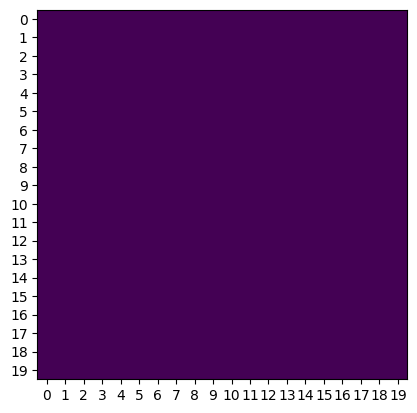

In [89]:

energy_samples, magnetization_samples = simulate(model, 1.2, 3000, 1500, 1)

model.plot_lattice()


Extend now the code above to repeat the calculation for temperatures between $kT=0$ and $kT=4$, with intervals of $kT=0.2$. Store the results in a NumPy array, and plot both the magnetization and energy

Question: do you see any changes in the energy and magnetization near $kT \approx 2.3$ ? What is your interpretation of this phenomena?

In [90]:

model = IsingModel(20, 20, 1.0, 0.0)

dkt = 0.2
kt_values = np.arange(dkt, 4.0+dkt, dkt)

m_values = np.zeros(len(kt_values)) 
e_values = np.zeros(len(kt_values)) 

print("About to loop")
for i, kt in enumerate(kt_values):
    print("i = {}, kT = {}".format(i, kt))
    energy_samples, magnetization_samples = simulate(model, kt, 3000, 1500, 1)
    m_values[i] = np.sum(magnetization_samples)/len(magnetization_samples)
    e_values[i] = np.sum(energy_samples)/len(energy_samples)
    

About to loop
i = 0, kT = 0.2
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 0.200000
	3000 total sweeps, 1500 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.000000
	<E> = -2.000000 +/- 0.000000
	<m> = 1.000000 +/- 0.000000
	Simulation finished. Took 18.183946132659912 sec.
i = 1, kT = 0.4
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 0.400000
	3000 total sweeps, 1500 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.000000
	<E> = -2.000000 +/- 0.000000
	<m> = 1.000000 +/- 0.000000
	Simulation finished. Took 18.71263074874878 sec.
i = 2, kT = 0.6000000000000001
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 0.600000
	3000 total sweeps, 1500 of them burn sweeps
		Sampling eve

Text(0, 0.5, '<m>')

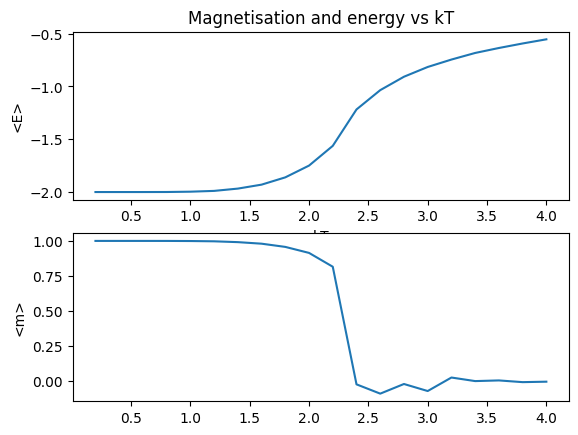

In [91]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(kt_values, e_values)
ax2.plot(kt_values, m_values)
ax1.set_title("Magnetisation and energy vs kT")
ax1.set_xlabel("kT")
ax1.set_ylabel("<E>")
ax2.set_ylabel("<m>")


**Answer**: a phase transition with spontaneous net magnetisation as kT goes below ~2.3.

## Fluctuations and dissipations

Well done! You've now run your first Metropolis simulation and used it to model phase transition in a ferromagnet. In this last section, we will explore an interesting phenomena: the hidden relation between fluctuations and dissipation. 

To do this we will first introduce you to the concept of fluctuations on the values you are measurring from your statistical ensemble. You can think of these fluctuations as error bars on the values you calculate. In any statistical ensemble,
or repeated physical experiment, you can calculate the error from these fluctuations by obtaining the mean deviance (e.g. what is your average difference from the median), which can also be rewritten: 

$ \sigma = \left ( < E^2 > - <E>^2 \right) $.

In this case we are in particular interested in the error bars obtained for the measured energy $E$. For an ensemble
of $N$ measurements, this formula can be rewritten as: 

$ \sigma = \left ( \frac{\sum_{i=1}^{N}{E_{i}^2}} { N  }  - (\frac{\sum_{i=1}^{N}{E_{i}}}{N})^2 \right) $.

Where $E_{i}$ is the energy obtained for the i'th measurement. 

calculate the statistical error bars obtained during the Monte Carlo simulation, according to the formula
mentioned above. For this, you'll need to update the line of code which measures the energy, now you'd like
to measure both the energy and the energy squared ($E$ and $E^2$). 

This equation, always verified at equilibrium, connects the dissipation (how much energy is required to heat the system),
with the size of fluctuations of the system. It is both a remarkable physical property, and also a useful tool for
performing calculations: using the relation you can obtain a precise estimate of the specific without needing to carrying out several calculations,
as required by the definition of $C$ which requires two data sets to evaluate the derivitive, and can suffer from discretization errors.

In the cell below, generalize your code to calculate $\sigma$, and compare with the estimate of $C$ obtained by using
the data obtained in the previous section.

In [92]:
def energy_statistics(energy_samples, kT):
    """
    Given an array of energy samples (per spin) at temperature kT,
    compute <E>, <E^2>, sigma = <E^2> - <E>^2, and error bar on <E>.
    """
    E_mean  = np.mean(energy_samples)
    E2_mean = np.mean(energy_samples**2)
    sigma   = E2_mean - E_mean**2           # fluctuation of energy

    N = len(energy_samples)

    C_fluct = sigma / (kT**2)               # specific heat from fluctuation formula

    return E_mean, E2_mean, sigma, C_fluct


model = IsingModel(20, 20, 1.0, 0.0)

kT = 2.2
energy_samples, magnetization_samples = simulate(model, kT, 5000, 2000, 1)

E_mean, E2_mean, sigma, C_fluct = energy_statistics(energy_samples, kT)

print("At kT = ", kT)
print("<E>     = {:.5f}".format(E_mean))
print("<E^2>   = {:.5f}".format(E2_mean))
print("sigma   = <E^2> - <E>^2 = {:.5f}".format(sigma))
print("C_fluct = sigma / T^2   = {:.5f}".format(C_fluct))


Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 2.200000
	5000 total sweeps, 2000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.146783
	<E> = -1.557470 +/- 0.004390
	<m> = 0.805317 +/- 0.003649
	Simulation finished. Took 31.45513391494751 sec.
At kT =  2.2
<E>     = -1.55747
<E^2>   = 2.44077
sigma   = <E^2> - <E>^2 = 0.01505
C_fluct = sigma / T^2   = 0.00311


You might also recall another interesting physical observable associated with the energy, the specific heat. This
latter quantity measures how much energy is required to increase the temperature of the system, or more specifically:

$ C = \frac{d E }{ dT} $

from the data obtained in the previous section, estimate the specific heat by calculating how the average energy changes as a function of temperature. Hint: consider two different temperatures and calculate the difference in average energies obtained.

Compare both, and in particular verify the relation :

$C = \frac{1}{T^2} \sigma $

In [96]:
def specific_heat_taylor(T0, dT, L=20, J=1.0, h=0.0,
                         num_sweeps=5000, num_burn=2000, sample_freq=1):
    # T_minus = T0 - dT, T_plus = T0 + dT
    T_minus = T0 - dT
    T_plus  = T0 + dT

    # simulate at T_minus
    model_minus = IsingModel(L, L, J, h)
    E_minus_samples, _ = simulate(model_minus, T_minus, num_sweeps, num_burn, sample_freq)
    E_minus_mean, _, _, _ = energy_statistics(E_minus_samples, T_minus)

    # simulate at T_plus
    model_plus = IsingModel(L, L, J, h)
    E_plus_samples, _ = simulate(model_plus, T_plus, num_sweeps, num_burn, sample_freq)
    E_plus_mean,  _, _, _ = energy_statistics(E_plus_samples, T_plus)

    # central (Taylor) finite difference
    C_taylor = (E_plus_mean - E_minus_mean) / (2.0 * dT)
    return C_taylor

T0  = 2.2
dT  = 0.2
C_deriv = specific_heat_taylor(T0, dT)

# run at T0 to get sigma and C_fluct
model0 = IsingModel(20, 20, 1.0, 0.0)
E0_samples, _ = simulate(model0, T0, 5000, 2000, 1)
_, _, sigma0, C_fluct0 = energy_statistics(E0_samples, T0)

print("C_Taylor (derivative) at T0 = {:.2f}: {:.5f}".format(T0, C_deriv))
print("C_fluct  (sigma/T^2)   at T0 = {:.2f}: {:.5f}".format(T0, C_fluct0))

Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 2.000000
	5000 total sweeps, 2000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.079827
	<E> = -1.743953 +/- 0.002919
	<m> = 0.910782 +/- 0.001419
	Simulation finished. Took 30.91805124282837 sec.
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 2.400000
	5000 total sweeps, 2000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.266652
	<E> = -1.243883 +/- 0.005027
	<m> = 0.061092 +/- 0.018265
	Simulation finished. Took 30.66668176651001 sec.
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 2.200000
	5000 total sweeps, 2000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.149892
	<